In [1]:
%reset -f
import rdkit
import pycaret
import joblib

print('rdkit: %s' % rdkit.__version__)
print('pycaret: %s' % pycaret.__version__)
print('joblib: %s' % joblib.__version__)

rdkit: 2023.09.5
pycaret: 3.2.0
joblib: 1.3.2


In [2]:
%%time
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors

# Defining the SMILES strings for the cucumin varients
curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "F[B-]3(F)OC(/C=C/Cc1ccc(Br)cc1)=CC(/C=C/Cc2ccc(Br)cc2)=[O+]3",
    "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc3ccc2c1ccccc1n(C)c2c3)=C4)cc5",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

# Function to generate Morgan fingerprints safely
def generate_morgan_fingerprint_safe(smiles):
    """Generate Morgan fingerprint and handle errors gracefully."""
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return list(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))
    except Exception:
        return None
    return None

# Defining the molecule names and HOMO-LUMO Gap
molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-12', 'AD-13', 'AD-13-DMF', 'AD-14-Moore', 'AD-15', 'AD-15-DMF', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-3', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-8', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 3.191, 3.226, 3.228, 2.811, 2.971, 2.813, 3.231, 2.735, 2.878, 2.686, 3.215, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 2.97, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)

# apply morgan fingerprint to the curcumin_df dataframe
curcumin_df['Morgan_Fingerprints'] = curcumin_df['Smiles'].apply(generate_morgan_fingerprint_safe)
curcumin_df = curcumin_df[curcumin_df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
morgan_df = pd.DataFrame(curcumin_df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])

curcumin_df_mf = pd.concat([curcumin_df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)

CPU times: total: 234 ms
Wall time: 2.23 s


In [3]:
# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'HOMO_calc', 'LUMO_calc', 'LUMO_calib', 'LUMO_calib_stds',
    'HOMO_calib', 'HOMO_calib_stds','GAP_calc', 'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

In [4]:
curcumin_variants_dict = {
    "curcumin_variant00": "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "curcumin_variant01": "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "curcumin_variant02": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "curcumin_variant03": "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "curcumin_variant04": "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "curcumin_variant05": "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "curcumin_variant06": "F[B-]3(F)OC(/C=C/Cc1ccc(Br)cc1)=CC(/C=C/Cc2ccc(Br)cc2)=[O+]3",
    "curcumin_variant07": "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant08": "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant09": "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant10": "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "curcumin_variant11": "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "curcumin_variant12": "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "curcumin_variant13": "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "curcumin_variant14": "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "curcumin_variant15": "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "curcumin_variant16": "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant17": "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant18": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant19": "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "curcumin_variant20": "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "curcumin_variant21": "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant22": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant23": "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc3ccc2c1ccccc1n(C)c2c3)=C4)cc5",
    "curcumin_variant24": "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "curcumin_variant25": "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
}

In [4]:
%%time
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

# Dictionary to hold the dataframes
similarity_dfs = {}

# Function to calculate similarity
def calculate_similarity(fp1, fp2, metric="kulczynski"):
    if metric == "kulczynski":
        return DataStructs.KulczynskiSimilarity(fp1, fp2)
    else:
        raise ValueError(f"Unknown similarity metric: {metric}")

print("Processing similarity dataframes...")

# Loop over curcumin variants and create similarity dataframes
for key, smiles in curcumin_variants_dict.items():
    specific_mol = Chem.MolFromSmiles(smiles)
    specific_fp = AllChem.GetMorganFingerprintAsBitVect(specific_mol, 2, nBits=2048)

    # Calculate similarity and create a new dataframe with similarity scores
    opv_df_sim_segment = opv_df.copy()
    opv_df_sim_segment['mol'] = opv_df_sim_segment['smiles'].apply(Chem.MolFromSmiles)
    opv_df_sim_segment[f'similarity_{key}_morgan_kulczynski'] = opv_df_sim_segment['mol'].apply(
        lambda x: calculate_similarity(AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048), specific_fp)
    )

    # Filter top 36% similar molecules
    quantile_value = opv_df_sim_segment[f'similarity_{key}_morgan_kulczynski'].quantile(0.64)
    filtered_df = opv_df_sim_segment[opv_df_sim_segment[f'similarity_{key}_morgan_kulczynski'] >= quantile_value]

    # Keep only the relevant columns (initial columns + similarity)
    filtered_df = filtered_df[['smiles', 'mol', 'GAP_calib', f'similarity_{key}_morgan_kulczynski']]

    # Store the filtered dataframe in the dictionary
    similarity_dfs[f'{key}_morgan_kulczynski'] = filtered_df

print("Done processing similarity dataframes.")

# Dictionary to store DataFrames with Morgan fingerprints
similarity_dfs_top36 = {}

print("Processing similarity dataframes with Morgan fingerprints...")

# Process each dataframe in the similarity_dfs dictionary
for key, df in similarity_dfs.items():
    # Generate Morgan fingerprints for the smiles in the dataframe
    df['Morgan_Fingerprints'] = df['smiles'].apply(generate_morgan_fingerprint_safe)
    
    # Filter out rows where Morgan fingerprints could not be generated
    df = df[df['Morgan_Fingerprints'].notnull()].reset_index(drop=True)
    
    # Convert the list of fingerprints into a DataFrame
    morgan_df = pd.DataFrame(df['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
    
    # Concatenate the original DataFrame with the Morgan fingerprints DataFrame
    df_mf = pd.concat([df.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
    
    # Store the final DataFrame in the new dictionary
    similarity_dfs_top36[key] = df_mf
    
    print(f"Done processing {key} dataframe - shape {df_mf.shape}")

# Unpacking the dictionary to global variables
for curcumin_variants_dict in similarity_dfs_top36.keys():
    globals()[f'similarity_dfs_top36_{curcumin_variants_dict}'] = similarity_dfs_top36[curcumin_variants_dict]

print("Done processing similarity dataframes with Morgan fingerprints.")

Processing similarity dataframes...
Done processing similarity dataframes.
Processing similarity dataframes with Morgan fingerprints...
Done processing curcumin_variant00_morgan_kulczynski dataframe - shape (18725, 2052)
Done processing curcumin_variant01_morgan_kulczynski dataframe - shape (18725, 2052)
Done processing curcumin_variant02_morgan_kulczynski dataframe - shape (18558, 2052)
Done processing curcumin_variant03_morgan_kulczynski dataframe - shape (18664, 2052)
Done processing curcumin_variant04_morgan_kulczynski dataframe - shape (18607, 2052)
Done processing curcumin_variant05_morgan_kulczynski dataframe - shape (18589, 2052)
Done processing curcumin_variant06_morgan_kulczynski dataframe - shape (18561, 2052)
Done processing curcumin_variant07_morgan_kulczynski dataframe - shape (18590, 2052)
Done processing curcumin_variant08_morgan_kulczynski dataframe - shape (18590, 2052)
Done processing curcumin_variant09_morgan_kulczynski dataframe - shape (18754, 2052)
Done processin

In [5]:
%%time
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

curcumin_variants_dict = {
    "curcumin_variant00": "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "curcumin_variant01": "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "curcumin_variant02": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "curcumin_variant03": "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "curcumin_variant04": "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "curcumin_variant05": "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "curcumin_variant06": "F[B-]3(F)OC(/C=C/Cc1ccc(Br)cc1)=CC(/C=C/Cc2ccc(Br)cc2)=[O+]3",
    "curcumin_variant07": "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant08": "C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant09": "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant10": "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "curcumin_variant11": "CCCOc1cc(N(CC)CC)ccc1C/C=C/C3=CC(/C=C/Cc2ccc(N(CC)CC)cc2OCCC)=[O+][B-](F)(F)O3",
    "curcumin_variant12": "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "curcumin_variant13": "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "curcumin_variant14": "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "curcumin_variant15": "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "curcumin_variant16": "N#Cc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant17": "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant18": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant19": "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "curcumin_variant20": "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "curcumin_variant21": "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant22": "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "curcumin_variant23": "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc3ccc2c1ccccc1n(C)c2c3)=C4)cc5",
    "curcumin_variant24": "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "curcumin_variant25": "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
}

# Define the similarity method and curcumin variants
similarity_method = 'morgan_kulczynski'
curcumin_variants = list(curcumin_variants_dict.keys())

# Create a list of tuples for dataframes using the chosen similarity method
dataframes = [
    (f'similarity_dfs_top36_{variant}_{similarity_method}', globals()[f'similarity_dfs_top36_{variant}_{similarity_method}'])
    for variant in curcumin_variants
]

# Define the LightGBM model with the specified parameters
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.1,
    n_estimators=100,
    random_state=123
)

results = []
best_models = {}  # Dictionary to store the best models by variant name

for name, df in dataframes:
    print(f"Processing {name}...")
    X = df.iloc[:, 4:]
    y = df['GAP_calib']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    
    # Store the model and its R2 score
    best_models[name] = lgb_model
    results.append({'variant': name, 'r2_score': r2})

    print(f"Done processing {name} with R2 score: {r2:.4f}")

# Convert results to a DataFrame
final_results_top36 = pd.DataFrame(results)

# Display the first few rows of the final results
final_results_top36.head()

Processing similarity_dfs_top36_curcumin_variant00_morgan_kulczynski...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2390
[LightGBM] [Info] Number of data points in the train set: 14043, number of used features: 1195
[LightGBM] [Info] Start training from score 2.772994
Done processing similarity_dfs_top36_curcumin_variant00_morgan_kulczynski with R2 score: 0.8947
Processing similarity_dfs_top36_curcumin_variant01_morgan_kulczynski...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2378
[LightGBM] [Info] Number of data points in the train set: 14043, number of used features: 11

,variant,r2_score
0,similarity_dfs_top36_curcumin_variant00_morgan...,0.894683
1,similarity_dfs_top36_curcumin_variant01_morgan...,0.891109
2,similarity_dfs_top36_curcumin_variant02_morgan...,0.886815
3,similarity_dfs_top36_curcumin_variant03_morgan...,0.885748
4,similarity_dfs_top36_curcumin_variant04_morgan...,0.880483


In [6]:
# Initialize an empty list to store the predicted energy gaps
predicted_energy_gaps = []

# Iterate through each row in the curcumin_df
for index, row in curcumin_df.iterrows():
    # Extract the variant number from the index
    variant_number = f'{index:02d}'  # Format index to match the two-digit variant in model names
    
    # Construct the model key using the variant number
    model_key = f'similarity_dfs_top36_curcumin_variant{variant_number}_morgan_kulczynski'
    
    # Get the corresponding model from the best_models dictionary
    model = best_models.get(model_key)
    
    if model is not None:
        # Extract the fingerprint data (columns 6 to end)
        fingerprint_data = row.iloc[5:].values.reshape(1, -1)
        
        # Predict the energy gap using the model
        energy_gap = model.predict(fingerprint_data)[0]
        predicted_energy_gaps.append(energy_gap)
    else:
        # If no model is found, append None
        predicted_energy_gaps.append(None)

# Add the predictions as a new column to curcumin_df
curcumin_df['Homo-Lumo Gap (eV) Predicted'] = predicted_energy_gaps

# Display the updated dataframe
curcumin_df

,Molecule,Molecular Weight,LogP,Homo-Lumo Gap (eV),Smiles,morgan_0,morgan_1,morgan_2,morgan_3,morgan_4,...,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047,Homo-Lumo Gap (eV) Predicted
0,2-ADMeO3,532.345,5.02930,3.077,COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.162326
1,3-MR83a,472.293,5.01210,3.072,COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.159680
2,AD-10,472.293,5.01210,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.921301
3,AD-1013,482.335,7.29270,2.625,COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1cc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.023356
4,AD-1022,472.293,5.01210,2.938,COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)...,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.930718
5,AD-11,444.239,4.40610,2.946,COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+]...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.035397
6,AD-12,509.981,6.50270,3.191,F[B-]3(F)OC(/C=C/Cc1ccc(Br)cc1)=CC(/C=C/Cc2ccc...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.250347
7,AD-13,464.317,6.21190,3.226,C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)c...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.062199
8,AD-13-DMF,464.317,6.21190,3.228,C=C(OC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C(=C)OC)c...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.062199
9,AD-14-Moore,438.327,5.10970,2.811,CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3.230558


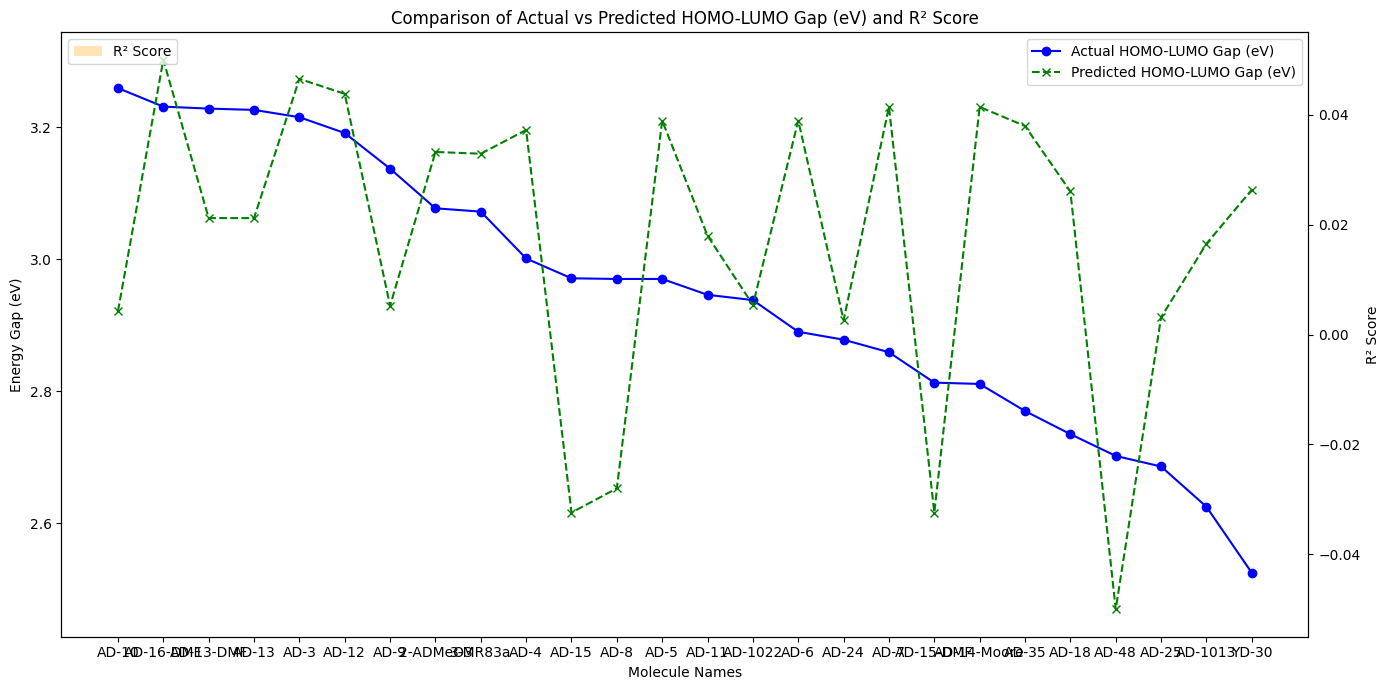

In [9]:
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Assuming curcumin_df already has a 'Homo-Lumo Gap (eV) Predicted' column from the previous steps

# Sort curcumin_df by 'Homo-Lumo Gap (eV)' in descending order and reset the index
curcumin_df = curcumin_df.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Calculate the R² score between 'Homo-Lumo Gap (eV)' and "Homo-Lumo Gap (eV) Predicted" for each row
curcumin_df['r2_score'] = curcumin_df.apply(
    lambda row: r2_score([row['Homo-Lumo Gap (eV)']], [row['Homo-Lumo Gap (eV) Predicted']]),
    axis=1
)

# Plotting the actual vs predicted energy gaps
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the actual values
ax1.plot(curcumin_df['Molecule'], curcumin_df['Homo-Lumo Gap (eV)'], marker='o', label='Actual HOMO-LUMO Gap (eV)', color='blue')

# Plot the predicted values
ax1.plot(curcumin_df['Molecule'], curcumin_df['Homo-Lumo Gap (eV) Predicted'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='green')

# Set labels for the first y-axis
ax1.set_xlabel('Molecule Names')
ax1.set_ylabel('Energy Gap (eV)')
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

# Create a secondary y-axis for the R² scores
ax2 = ax1.twinx()
ax2.bar(curcumin_df['Molecule'], curcumin_df['r2_score'], alpha=0.3, label='R² Score', color='orange')

# Set labels for the secondary y-axis
ax2.set_ylabel('R² Score')
ax2.tick_params(axis='y')
ax2.legend(loc='upper left')

# Customize the plot
plt.title('Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and R² Score')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Show the plot
plt.show()

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming curcumin_df already has a 'Homo-Lumo Gap (eV) Predicted' column from the previous steps

# Sort curcumin_df by 'Homo-Lumo Gap (eV)' in descending order and reset the index
curcumin_df = curcumin_df.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Predicted'
curcumin_df['absolute_variance'] = (curcumin_df['Homo-Lumo Gap (eV)'] - curcumin_df['Homo-Lumo Gap (eV) Predicted']).abs()

# Plotting the actual vs predicted energy gaps
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the actual values
ax1.plot(curcumin_df['Molecule'], curcumin_df['Homo-Lumo Gap (eV)'], marker='o', label='Actual HOMO-LUMO Gap (eV)', color='blue')

# Plot the predicted values
ax1.plot(curcumin_df['Molecule'], curcumin_df['Homo-Lumo Gap (eV) Predicted'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='green')

# Plot the absolute variance as a dotted line
ax1.plot(curcumin_df['Molecule'], curcumin_df['absolute_variance'], marker='d', linestyle=':', label='Absolute Variance', color='orange')

# Set labels for the y-axis and the range
ax1.set_xlabel('Molecule Names')
ax1.set_ylabel('Energy Gap (eV)')
ax1.set_ylim([0, 4])  # Y-axis range from 0 to 4
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

# Customize the plot
plt.figure(figsize=(9, 4))
plt.title('Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance')
plt.xticks(rotation=90)  # Rotate x-axis labels vertically
plt.tight_layout()

# Show the plot
plt.show()

KeyError: 'Homo-Lumo Gap (eV) Predicted'

In [11]:
overall_r2 = r2_score(curcumin_df['Homo-Lumo Gap (eV)'], curcumin_df['Homo-Lumo Gap (eV) Predicted'])
print(f"Overall R² score: {overall_r2:.4f}")

Overall R² score: -0.8059
